
## COMP5318 Assignment 2



# Forest Fires Area Prediction - SVR model

## 1. Load Library

In [292]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler # Standardization(Z-score normalisation) mu=0 sd=1
from sklearn.preprocessing import MinMaxScaler # Rescaling (min-max normalisation) min=0 max=1

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # for best parameters
from sklearn.svm import SVR  # Epsilon-Support Vector Regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import cross_val_score

import math
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

## 2. Read Dataset - forestfires.csv

In [312]:
##### Read Dataset
# dataset is downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv
df = pd.read_csv("forestfires.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [313]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


array([[<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DC'}>],
       [<AxesSubplot:title={'center':'ISI'}>,
        <AxesSubplot:title={'center':'rain'}>]], dtype=object)

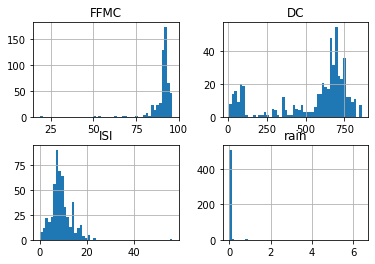

In [314]:
df[['FFMC','DC','ISI','rain']].hist(bins=50)

In [315]:
df['day'].unique(),df['month'].unique()

(array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object),
 array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
        'dec', 'may', 'nov'], dtype=object))

In [316]:
##### Check outliers

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print("IQR score:")
print(IQR,"\n")

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = ((df < (lower)) | (df > (upper))).sum()
print("Number of outliers:")
print(outliers,"\n")

outlier_per=(((df < (lower)) | (df > (upper))).sum())/len(df)*100
print("Percentage of outliers: %")
print(outlier_per)

IQR score:
X         4.00
Y         1.00
FFMC      2.70
DMC      73.80
DC      276.20
ISI       4.30
temp      7.30
RH       20.00
wind      2.20
rain      0.00
area      6.57
dtype: float64 

Number of outliers:
DC        8
DMC      17
FFMC     53
ISI      23
RH       12
X         0
Y        51
area     63
day       0
month     0
rain      8
temp      2
wind     13
dtype: int64 

Percentage of outliers: %
DC        1.547389
DMC       3.288201
FFMC     10.251451
ISI       4.448743
RH        2.321083
X         0.000000
Y         9.864603
area     12.185687
day       0.000000
month     0.000000
rain      1.547389
temp      0.386847
wind      2.514507
dtype: float64


## 3. Experiment

## 3.1 OneHotEncoder  &  Log  &  StandardScale  &  All Features

In [317]:
##### OneHot Encoder

fire = df.copy()
label_encoder = OneHotEncoder()

month = np.array(fire['month']).reshape(-1,1)
day = np.array(fire['day']).reshape(-1,1)

label_encoder.fit(month)
m = label_encoder.transform(month).toarray()

label_encoder.fit(day)
d = label_encoder.transform(day).toarray()

month_df = pd.DataFrame(m, dtype=int)
day_df = pd.DataFrame(d, dtype=int)

In [318]:
df_full = pd.concat([fire, month_df, day_df],axis=1) # full dataset

features = df_full.drop(["month","day","area"], axis=1)  # all 29 features  (517, 29)
target = df_full["area"] # target  (517,)

In [319]:
##### Log transformation

features[['FFMC']+['DC']+['ISI']+['rain']] = np.log(features[['FFMC']+['DC']+['ISI']+['rain']]+1)
X = features.copy()
y = np.log1p(target)  # get log(target + 1)
y = np.array(y).reshape(-1,)

In [320]:
##### Split training / test data --- 90% / 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)


##### StandardScaler Transformation  mu=0 sd=1
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns=features.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=features.columns)

In [321]:
##### Choose SVR Kernel
parameters = [{'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svr_cv = GridSearchCV(SVR(), parameters, cv = 10)
svr_cv.fit(X_train, y_train)

print('Best parameters:',svr_cv.best_params_)

Best parameters: {'kernel': 'rbf'}


In [17]:
##### Choose SVR Parameter
parameters = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6],
               'epsilon':[0,0.1,0.01]}]
svr_cv = GridSearchCV(SVR(kernel='rbf'), parameters, cv = 10)
svr_cv.fit(X_train, y_train)

print('Best parameters:',svr_cv.best_params_)
print('Best estimator:',svr_cv.best_estimator_)

Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 1}
Best estimator: SVR(C=1, gamma=1)


In [439]:
##### Get Prediction & MAE & RMSE
pre_test = svr_cv.predict(X_test)
mae = mean_absolute_error(y_test,pre_test)
print("MAE on test set:",mae)

true_pred = np.expm1(pre_test) # inverse of log1p to get true predicted area
true_y = np.expm1(y_test)

mae_test = mean_absolute_error(true_y ,true_pred)
rmse_test = math.sqrt(mean_squared_error(true_y ,true_pred))
print("\nMAE on true test set:",mae_test)
print("RMSE on true test set:",rmse_test)

MAE on test set: 1.0306164737464032

MAE on true test set: 10.800090053436886
RMSE on true test set: 40.31473720803804


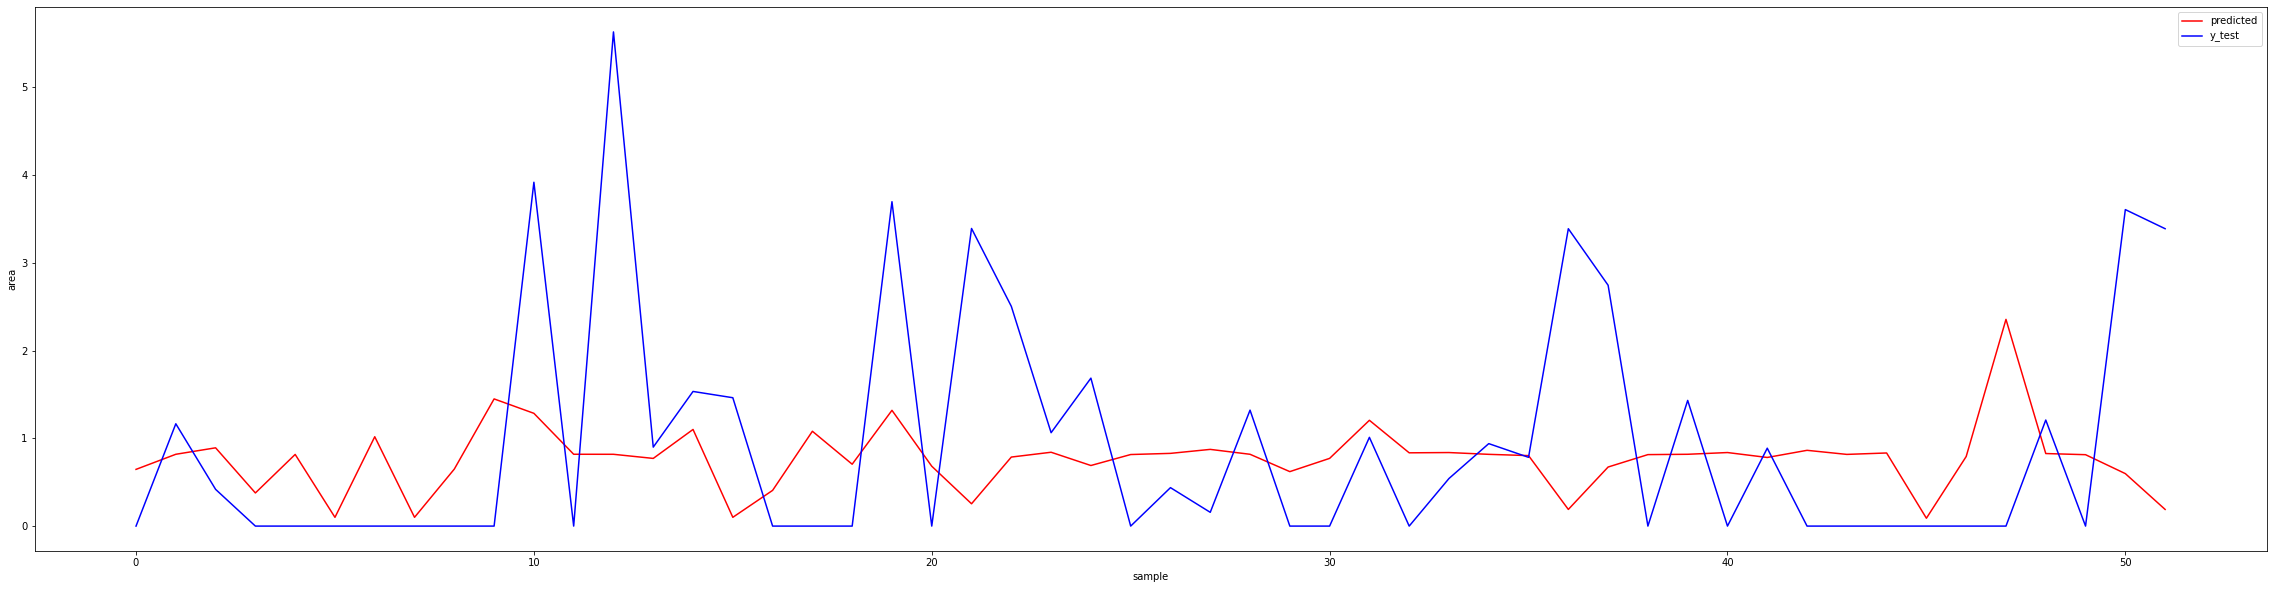

In [440]:
##### Visualise Prediction
plt.figure(figsize=(40, 10));
plt.plot(pre_test,color='r',label='predicted')
plt.plot(y_test,color='b',label='y_test')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

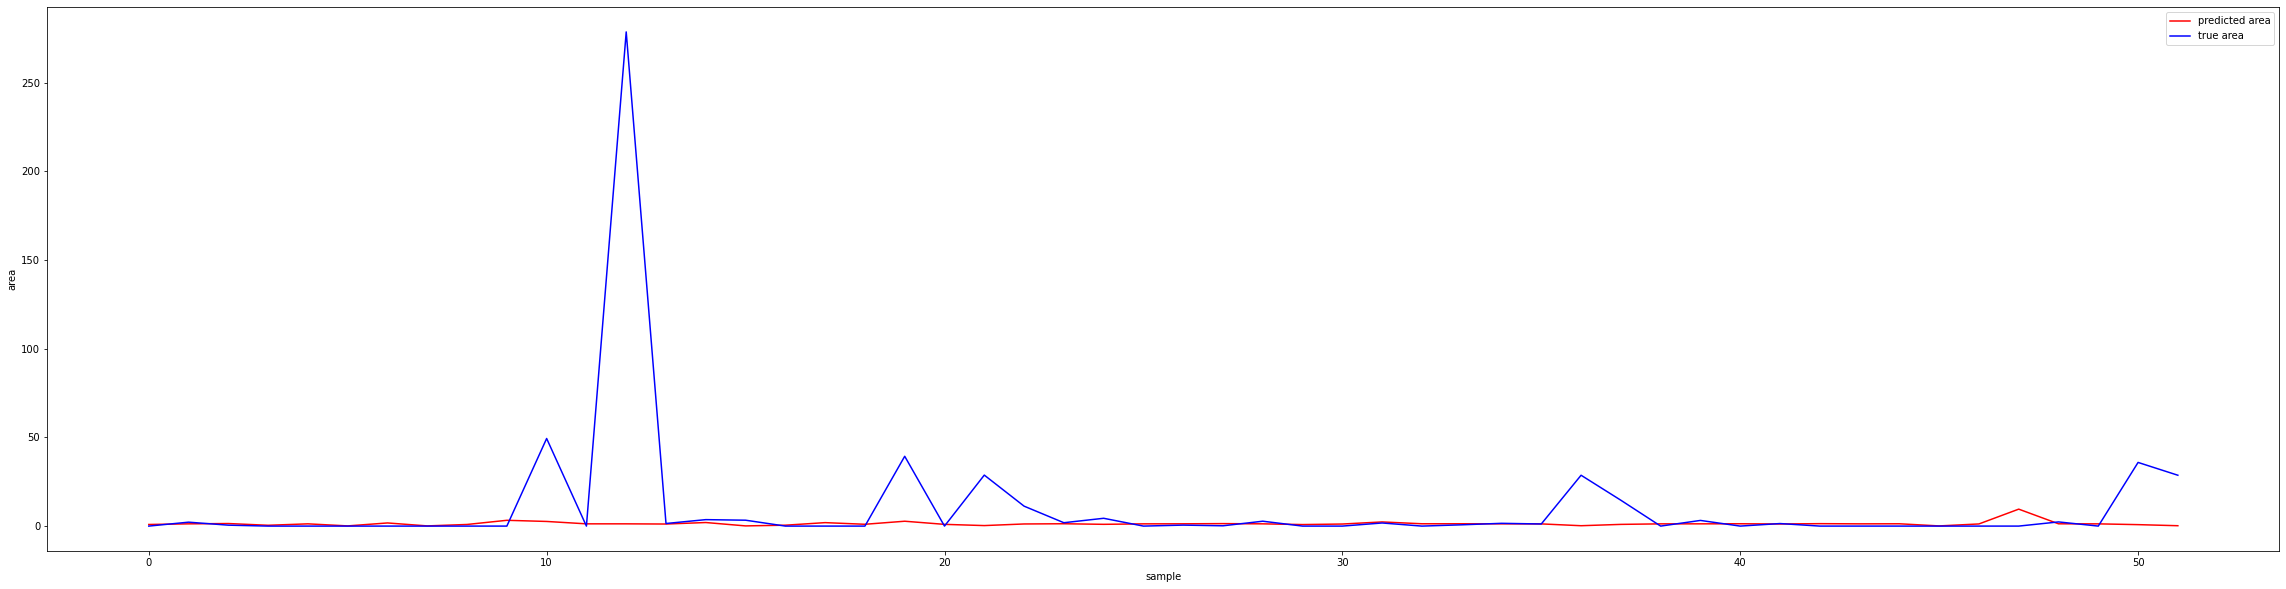

In [441]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(true_pred,color='r',label='predicted area')
plt.plot(true_y,color='b',label='true area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

## 3.2 LabelEncoder & Log & StandardScale & All Features

In [322]:
##### LabelEncoder
fire1 = df.copy()
label_encoder = LabelEncoder()

label_encoder.fit_transform(fire1['day'])
fire1['day']=label_encoder.transform(fire1['day'])
label_encoder.fit_transform(fire1['month'])
fire1['month']=label_encoder.transform(fire1['month'])

features1 = fire1.drop(["area"], axis=1)  # all 29 features  (517, 29)
target1 = fire1["area"] #target  (517,)

In [323]:
##### Log transformation
features1[['FFMC']+['DC']+['ISI']+['rain']] = np.log(features1[['FFMC']+['DC']+['ISI']+['rain']]+1)
X1 = features1.copy()

y1 = np.log1p(target1)  # get log(target + 1)
y1 = np.array(y1).reshape(-1,)

In [324]:
##### Split training / test data --- 90% / 10%
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=2)


##### StandardScaler Transformation  mu=0 sd=1
scaler1 = StandardScaler().fit(X1_train)
X1_train = pd.DataFrame(scaler1.transform(X1_train),columns=features1.columns)
X1_test = pd.DataFrame(scaler1.transform(X1_test),columns=features1.columns)

In [325]:
##### Choose SVR Kernel
parameters1 = [{'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svr_cv1 = GridSearchCV(SVR(), parameters1, cv = 10)
svr_cv1.fit(X1_train, y1_train)

print('Best parameters:',svr_cv1.best_params_)

Best parameters: {'kernel': 'rbf'}


In [29]:
##### Choose SVR Parameter
parameters1 = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6],
               'epsilon':[0,0.1,0.01]}]
svr_cv1 = GridSearchCV(SVR(kernel='rbf'), parameters1, cv = 10)
svr_cv1.fit(X1_train, y1_train)

print('Best parameters:',svr_cv1.best_params_)
print('Best estimator:',svr_cv1.best_estimator_)

Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 1}
Best estimator: SVR(C=1, gamma=1)


In [434]:
##### Get Prediction & MAE & RMSE
pre_test1 = svr_cv1.predict(X1_test)
mae1 = mean_absolute_error(y1_test, pre_test1)
print("MAE on test set:",mae1)

true_pred1 = np.expm1(pre_test1) # inverse of log1p to get true predicted area
true_y1 = np.expm1(y1_test)

mae_test1 = mean_absolute_error(true_y1, true_pred1)
rmse_test1 = math.sqrt(mean_squared_error(true_y1,true_pred1))
print("\nMAE on true test set:",mae_test1)
print("RMSE on true test set:",rmse_test1)

MAE on test set: 1.062554697518278

MAE on true test set: 10.868903081349178
RMSE on true test set: 40.3220571539252


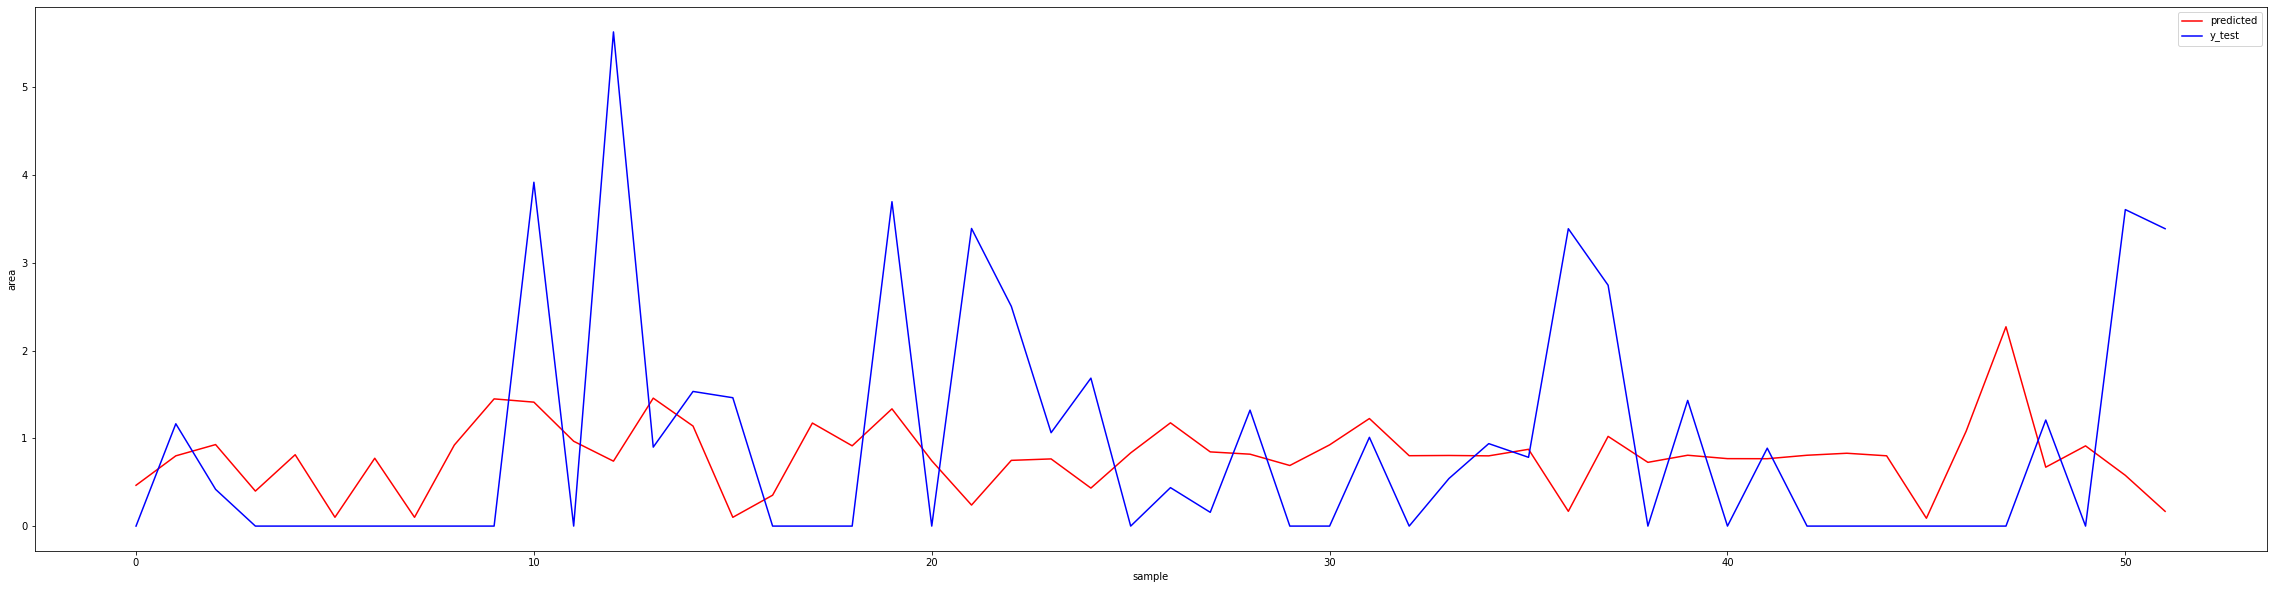

In [435]:
##### Visualise Prediction
plt.figure(figsize=(40, 10));
plt.plot(pre_test1,color='r',label='predicted')
plt.plot(y1_test,color='b',label='y_test')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

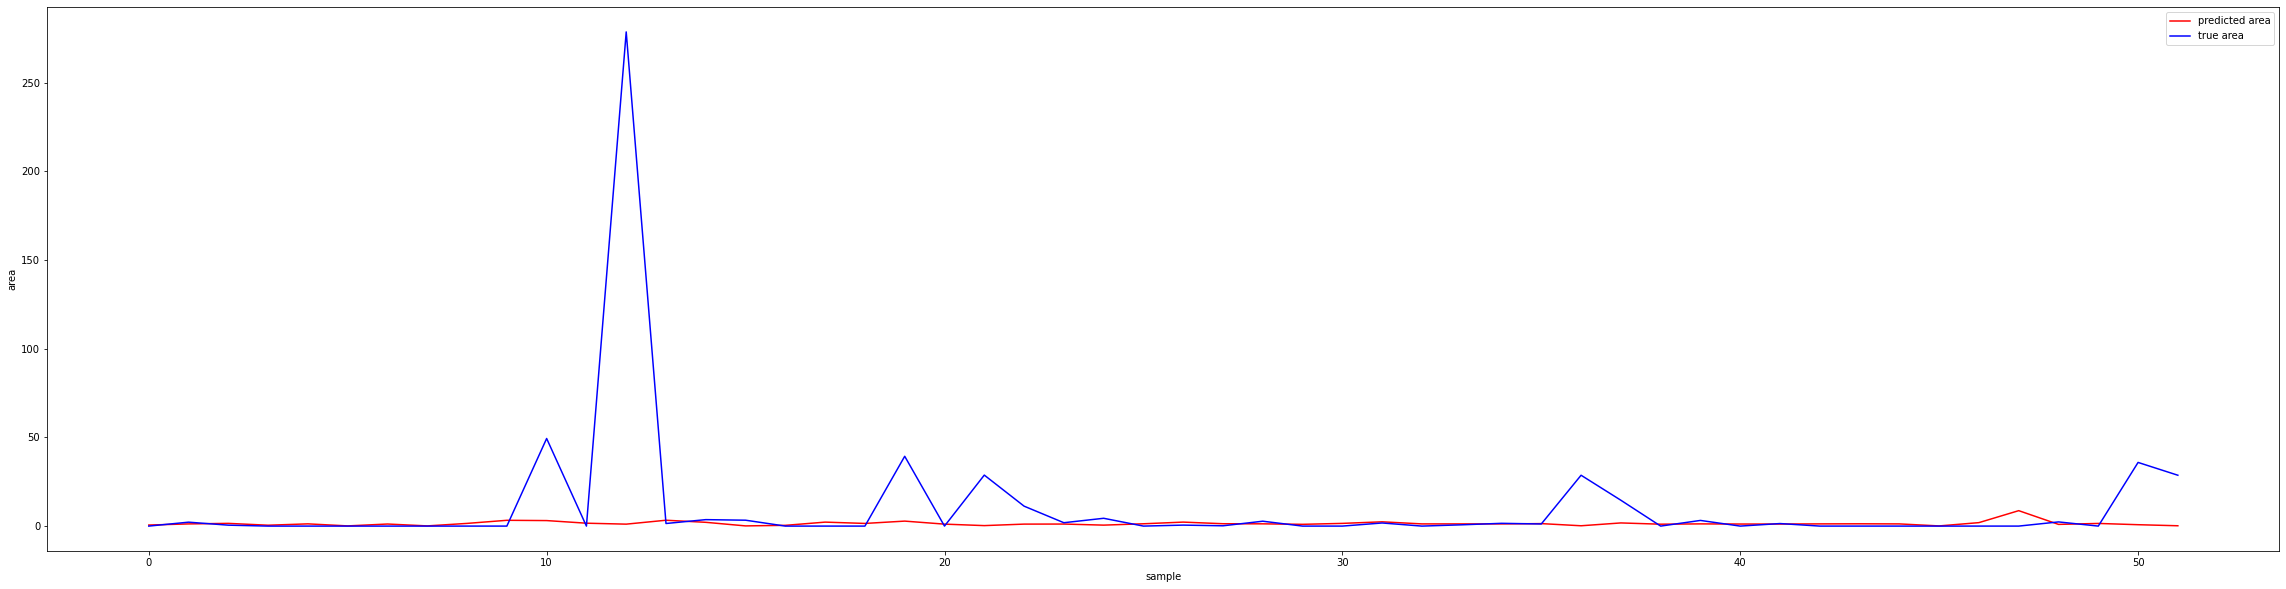

In [436]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(true_pred1,color='r',label='predicted area')
plt.plot(true_y1,color='b',label='true area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')


## 3.3 OneHotEncoder & Log & StandardScale & Remove FWIs

In [327]:
##### Drop FWI Columns (FFMC/DMC/DC/ISI)

fire2 = df_full.copy() # did OneHot Encoder
features2 = fire2.drop(["month","day","FFMC","DMC","DC","ISI","area"], axis=1)  # No FWIs (517, 25)
target2 = fire2["area"] #target  (517,)

In [329]:
##### Log transformation

features2[['rain']] = np.log(features2[['rain']]+1)
X2 = features2.copy()
y2 = np.log1p(target2)  # get log(target + 1)
y2 = np.array(y2).reshape(-1,)

In [332]:
##### Split training / test data --- 90% / 10%
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=2)


##### StandardScaler Transformation  mu=0 sd=1
scaler2 = StandardScaler().fit(X2_train)
X2_train = pd.DataFrame(scaler2.transform(X2_train),columns=features2.columns)
X2_test = pd.DataFrame(scaler2.transform(X2_test),columns=features2.columns)

In [333]:
##### Choose SVR Kernel
parameters2 = [{'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svr_cv2 = GridSearchCV(SVR(), parameters2, cv = 10)
svr_cv2.fit(X2_train, y2_train)

print('Best parameters:',svr_cv2.best_params_)

Best parameters: {'kernel': 'rbf'}


In [47]:
##### Choose SVR Parameter
parameters2 = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6],
               'epsilon':[0,0.1,0.01]}]
svr_cv2 = GridSearchCV(SVR(kernel='rbf'), parameters2, cv = 10)
svr_cv2.fit(X2_train, y2_train)

print('Best parameters:',svr_cv2.best_params_)
print('Best estimator:',svr_cv2.best_estimator_)

Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 1}
Best estimator: SVR(C=1, gamma=1)


In [431]:
##### Get Prediction & MAE & RMSE
pre_test2 = svr_cv2.predict(X2_test)
mae2 = mean_absolute_error(y2_test, pre_test2)
print("MAE on test set:",mae2)

true_pred2 = np.expm1(pre_test2) # inverse of log1p to get true predicted area
true_y2 = np.expm1(y2_test)

mae_test2 = mean_absolute_error(true_y2, true_pred2)
rmse_test2 = math.sqrt(mean_squared_error(true_y2, true_pred2))
print("\nMAE on true test set:",mae_test2)
print("RMSE on true test set:",rmse_test2)

MAE on test set: 1.0365328809832073

MAE on true test set: 10.795108083902248
RMSE on true test set: 40.32530902934865


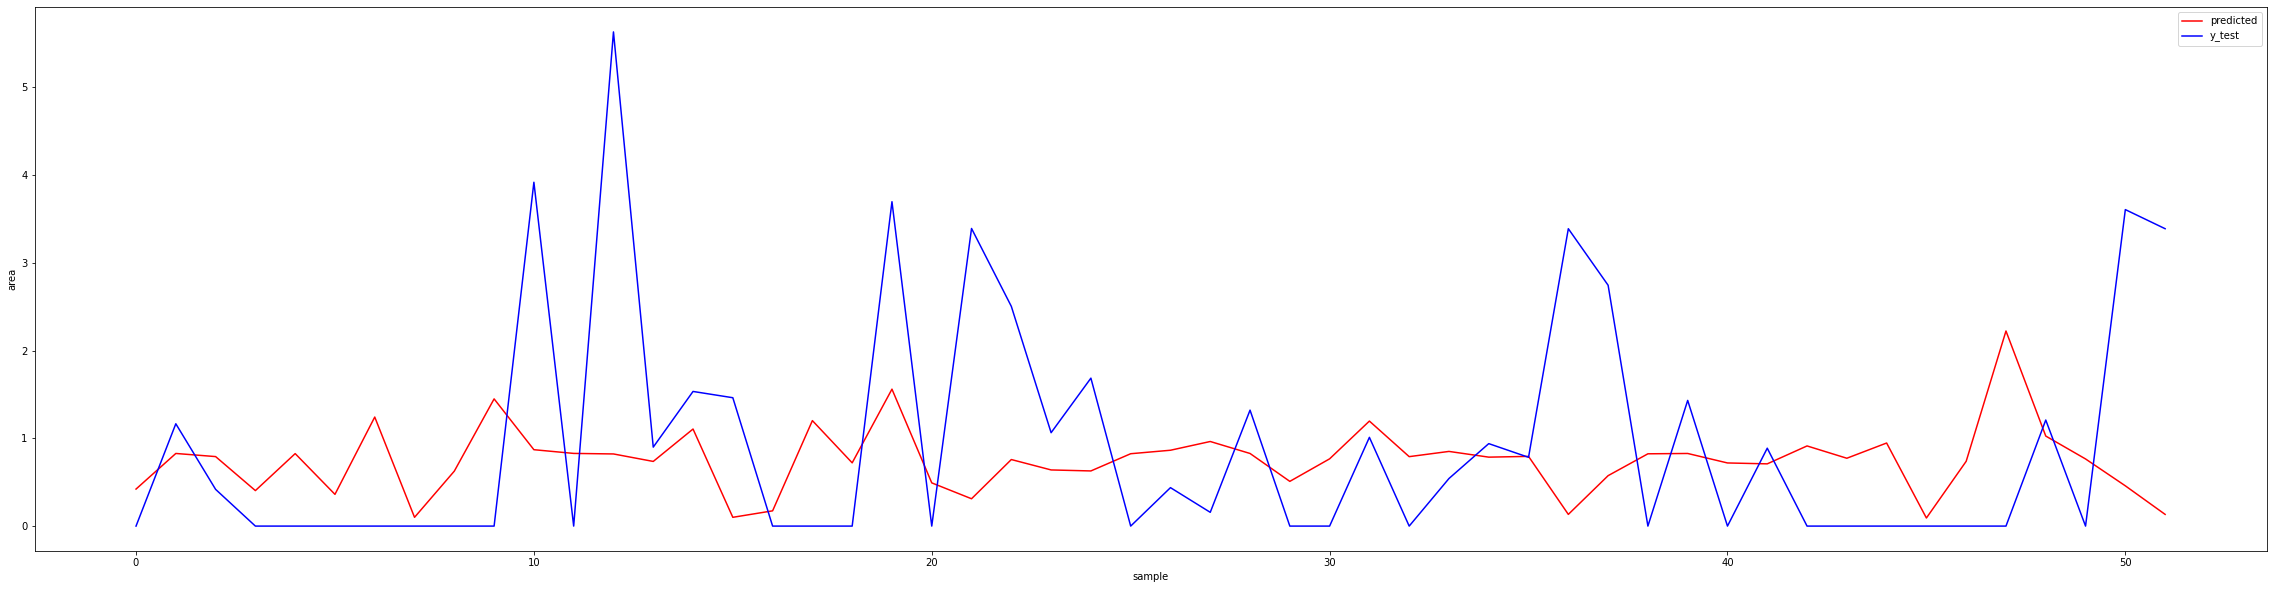

In [432]:
##### Visualise Prediction
plt.figure(figsize=(40, 10));
plt.plot(pre_test2,color='r',label='predicted')
plt.plot(y2_test,color='b',label='y_test')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

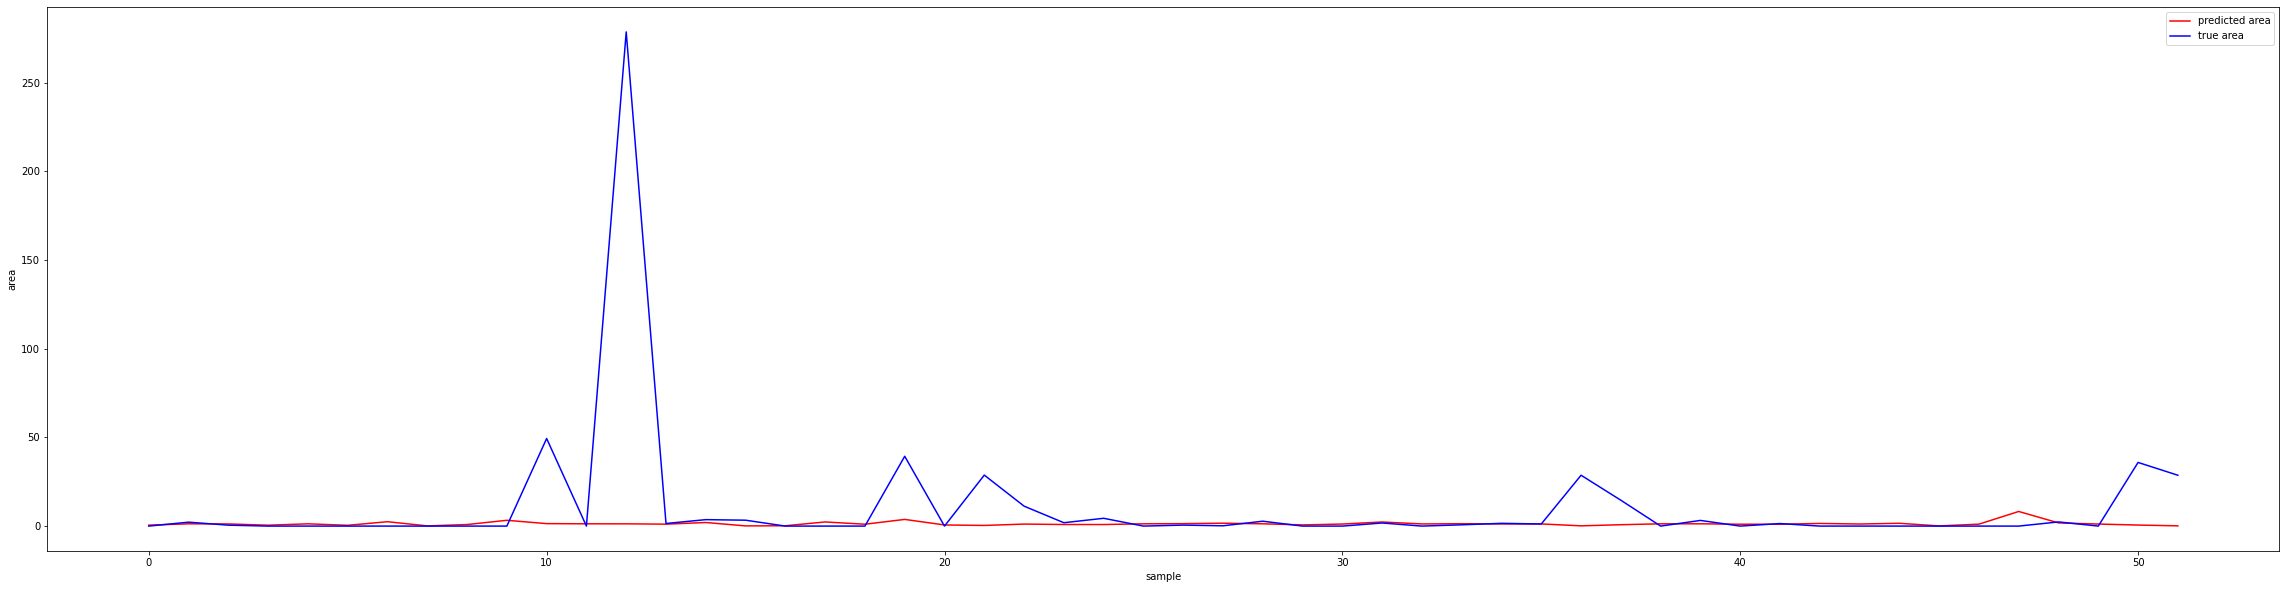

In [433]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(true_pred2,color='r',label='predicted area')
plt.plot(true_y2,color='b',label='true area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')


## 3.4 OneHotEncoder & Log & Normalisation & All Features

In [334]:
##### OneHot Encoder & Log Transformation

X3 = features.copy() # Did OneHot Encoder & Log in section 3.1
y3 = np.log1p(target)  # Log transformation of target
y3 = np.array(y3).reshape(-1,)

In [337]:
##### Split training / test data --- 90% / 10%
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.1, random_state=2)


##### Normalisation Transformation - Rescaling features min=0 max=1
minmaxscale = MinMaxScaler(feature_range=(0,1)).fit(X3_train) # MinMaxScaler
X3_train = pd.DataFrame(minmaxscale.transform(X3_train),columns=features.columns)
X3_test = pd.DataFrame(minmaxscale.transform(X3_test),columns=features.columns)

In [107]:
##### Choose SVR Parameter
parameters3 = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6]}]
svr_cv3 = GridSearchCV(SVR(kernel='rbf',epsilon=0.1), parameters3, cv = 10)
svr_cv3.fit(X3_train, y3_train)

print('Best parameters:',svr_cv3.best_params_)
print('Best estimator:',svr_cv3.best_estimator_)

Best parameters: {'C': 1000, 'gamma': 0.0001}
Best estimator: SVR(C=1000, gamma=0.0001)


In [428]:
##### Get Prediction & MAE & RMSE

pre_test3 = svr_cv3.predict(X3_test)
pre_test3[pre_test3<0]=0    # replace negative values to zero
mae3 = mean_absolute_error(y3_test,pre_test3)
print("MAE on test set:",mae3)

true_pred3 = np.expm1(pre_test3)  # inverse of log1p to get true predicted area
true_y3 = np.expm1(y3_test)
true_pred3[true_pred3<0]=0  # replace negative values to zero

mae_test3 = mean_absolute_error(true_y3, true_pred3)
rmse_test3 = math.sqrt(mean_squared_error(true_y3, true_pred3))
print("\nMAE on true test set:",mae_test3)
print("RMSE on true test set:",rmse_test3)

MAE on test set: 0.9748356151252151

MAE on true test set: 10.592660903888024
RMSE on true test set: 40.43658672584702


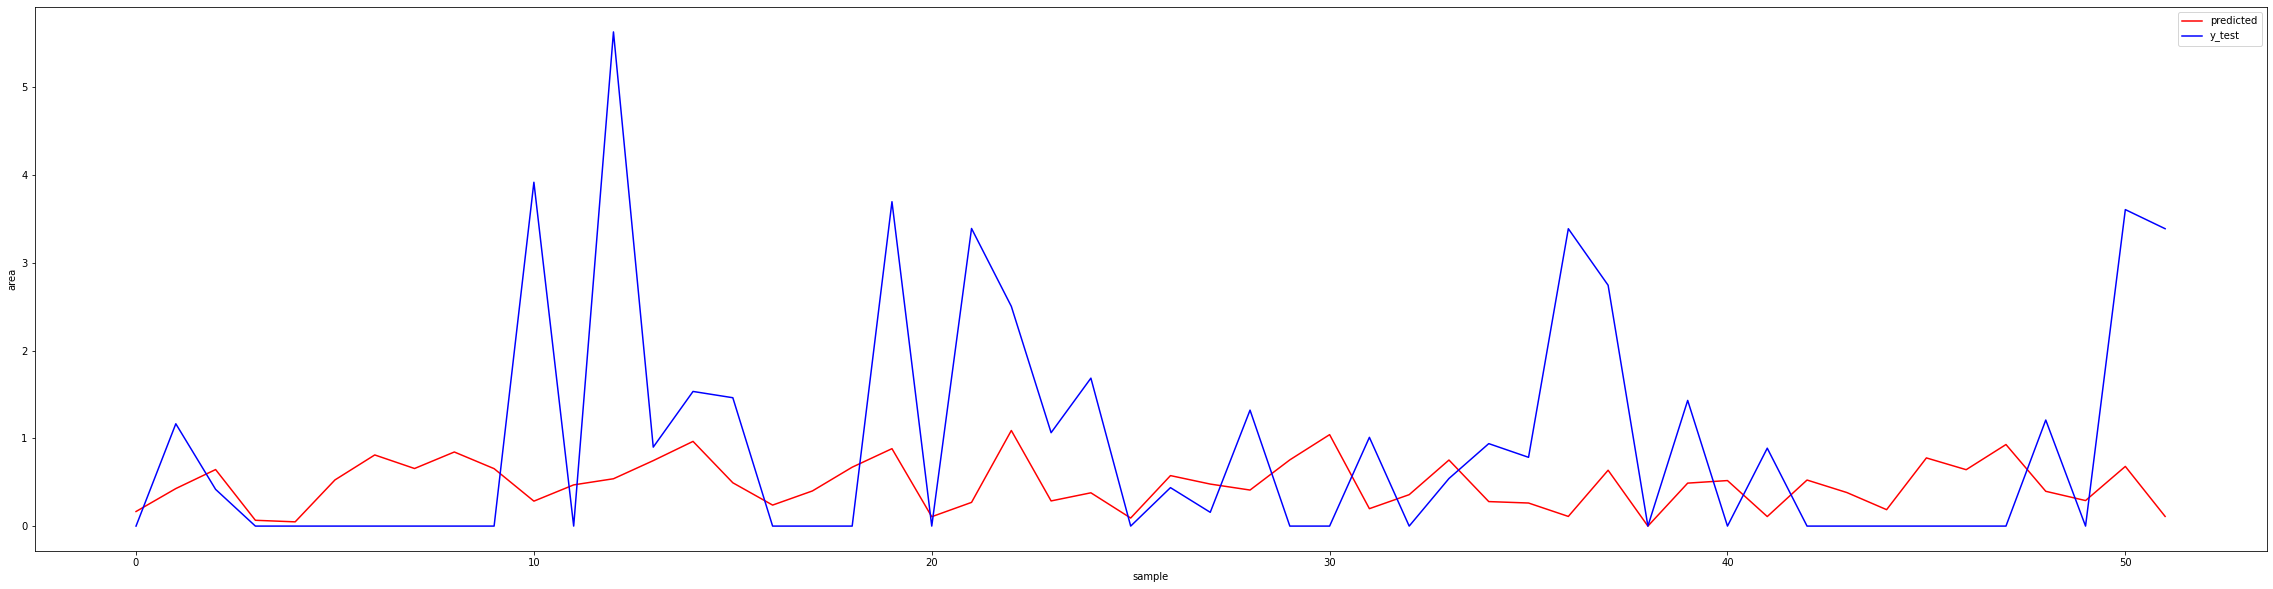

In [429]:
##### Visualise Prediction
plt.figure(figsize=(40, 10));
plt.plot(pre_test3,color='r',label='predicted')
plt.plot(y3_test,color='b',label='y_test')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

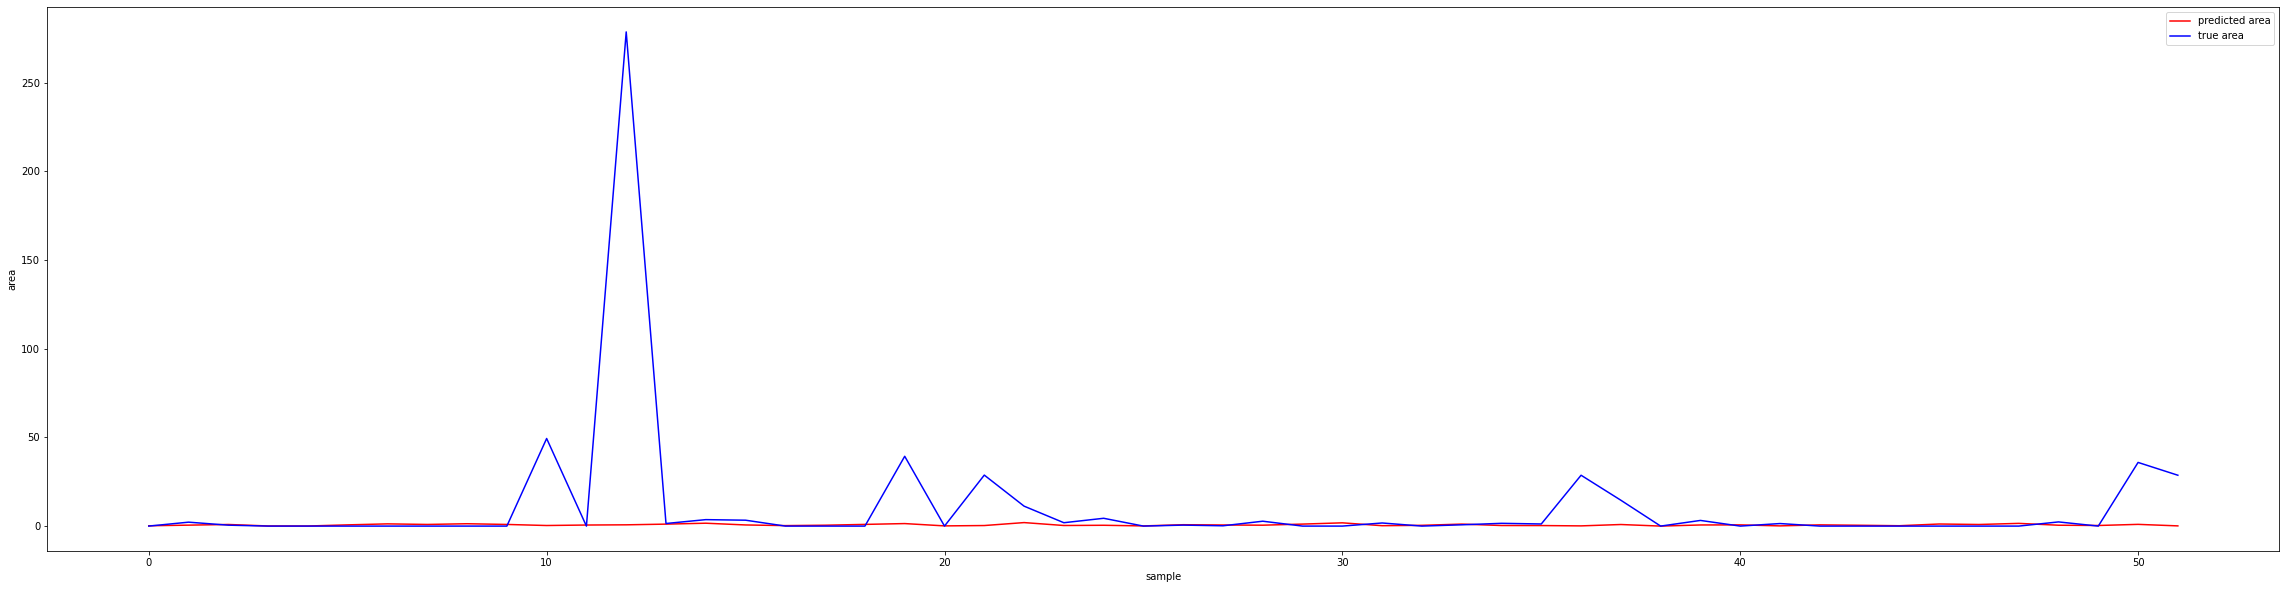

In [430]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(true_pred3,color='r',label='predicted area')
plt.plot(true_y3,color='b',label='true area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')


## 3.5 OneHotEncoder & Log & Normalisation & Remove FWIs

In [341]:
##### OneHot Encoder & Log Transformation & Remove FWIs

X4 = features2.copy() # Did OneHot Encoder & Log & Remove FWIs in Section 3.3
y4 = np.log1p(target)  # Log for target
y4 = np.array(y4).reshape(-1,)

In [344]:
##### Split training / test data --- 90% / 10%
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.1, random_state=2)


##### Normalisation Transformation - Rescaling features min=0 max=1
minmaxscale1 = MinMaxScaler(feature_range=(0,1)).fit(X4_train)
X4_train = pd.DataFrame(minmaxscale1.transform(X4_train),columns=X4.columns)
X4_test = pd.DataFrame(minmaxscale1.transform(X4_test),columns=X4.columns)

In [124]:
##### Choose SVR Parameter
parameters4 = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6]}]
svr_cv4 = GridSearchCV(SVR(kernel='rbf',epsilon=0.01), parameters4, cv = 10)
svr_cv4.fit(X4_train, y4_train)

print('Best parameters:',svr_cv4.best_params_)
print('Best estimator:',svr_cv4.best_estimator_)

Best parameters: {'C': 1000, 'gamma': 0.0001}
Best estimator: SVR(C=1000, epsilon=0.01, gamma=0.0001)


In [425]:
##### Get Prediction & MAE & RMSE

pre_test4 = svr_cv4.predict(X4_test)
pre_test4[pre_test4<0]=0    # replace negative values to zero
mae4 = mean_absolute_error(y4_test, pre_test4)
print("MAE on test set:",mae4)

true_pred4 = np.expm1(pre_test4)  # inverse of log1p to get true predicted area
true_y4 = np.expm1(y4_test)
true_pred4[true_pred4<0]=0  # replace negative values to zero

mae_test4 = mean_absolute_error(true_y4, true_pred4)
rmse_test4 = math.sqrt(mean_squared_error(true_y4, true_pred4))
print("\nMAE on true test set:",mae_test4)
print("RMSE on true test set:",rmse_test4)

MAE on test set: 0.9696935370860795

MAE on true test set: 10.588781606437088
RMSE on true test set: 40.44588401283518


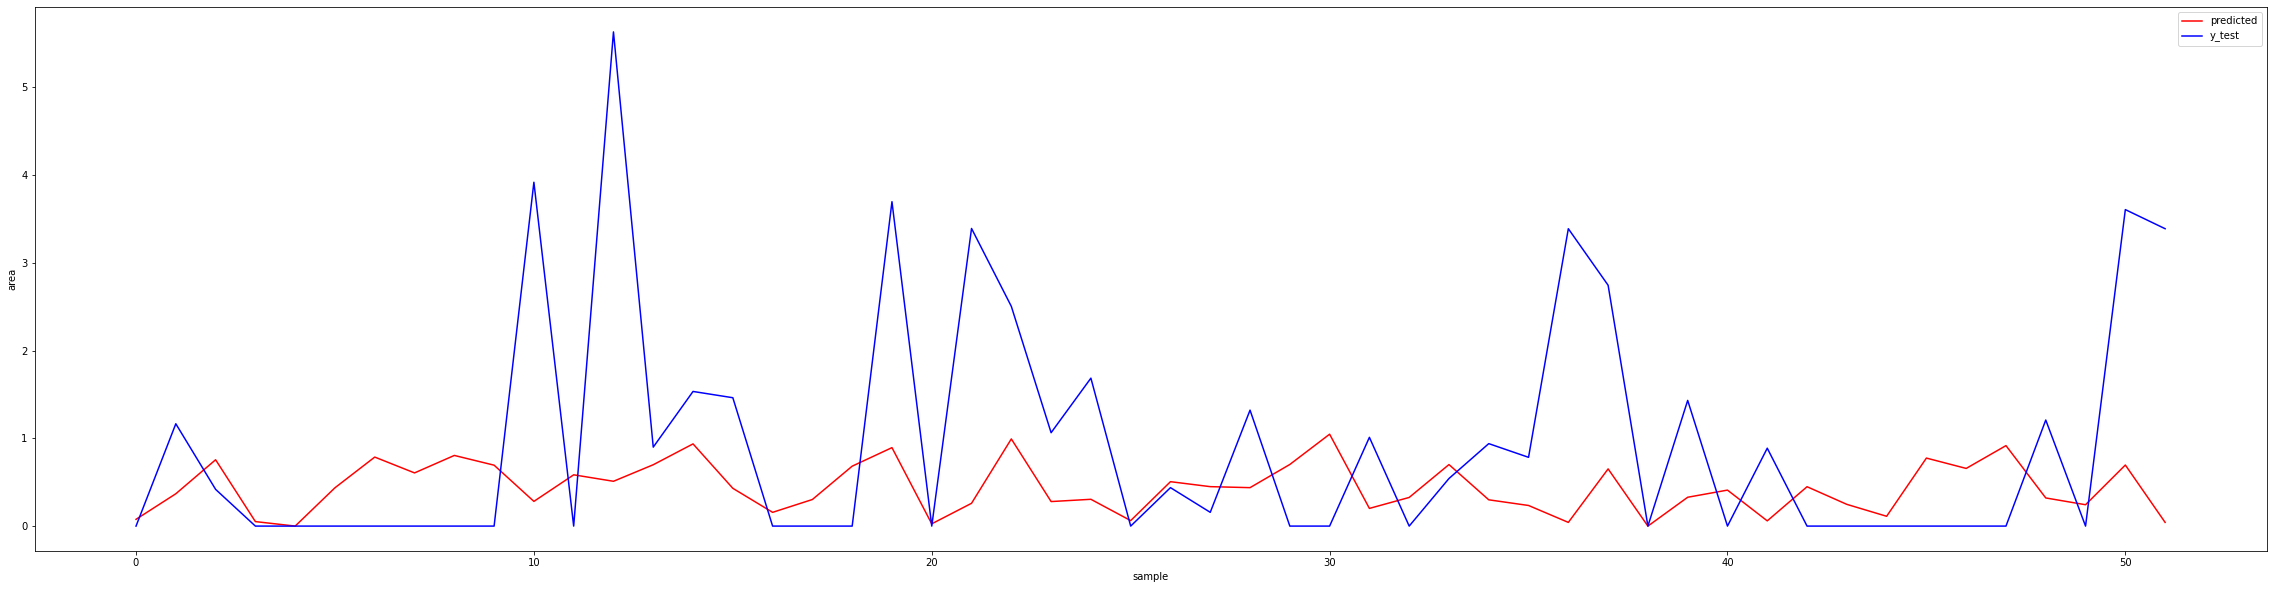

In [426]:
##### Visualise Prediction
plt.figure(figsize=(40, 10));
plt.plot(pre_test4,color='r',label='predicted')
plt.plot(y4_test,color='b',label='y_test')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

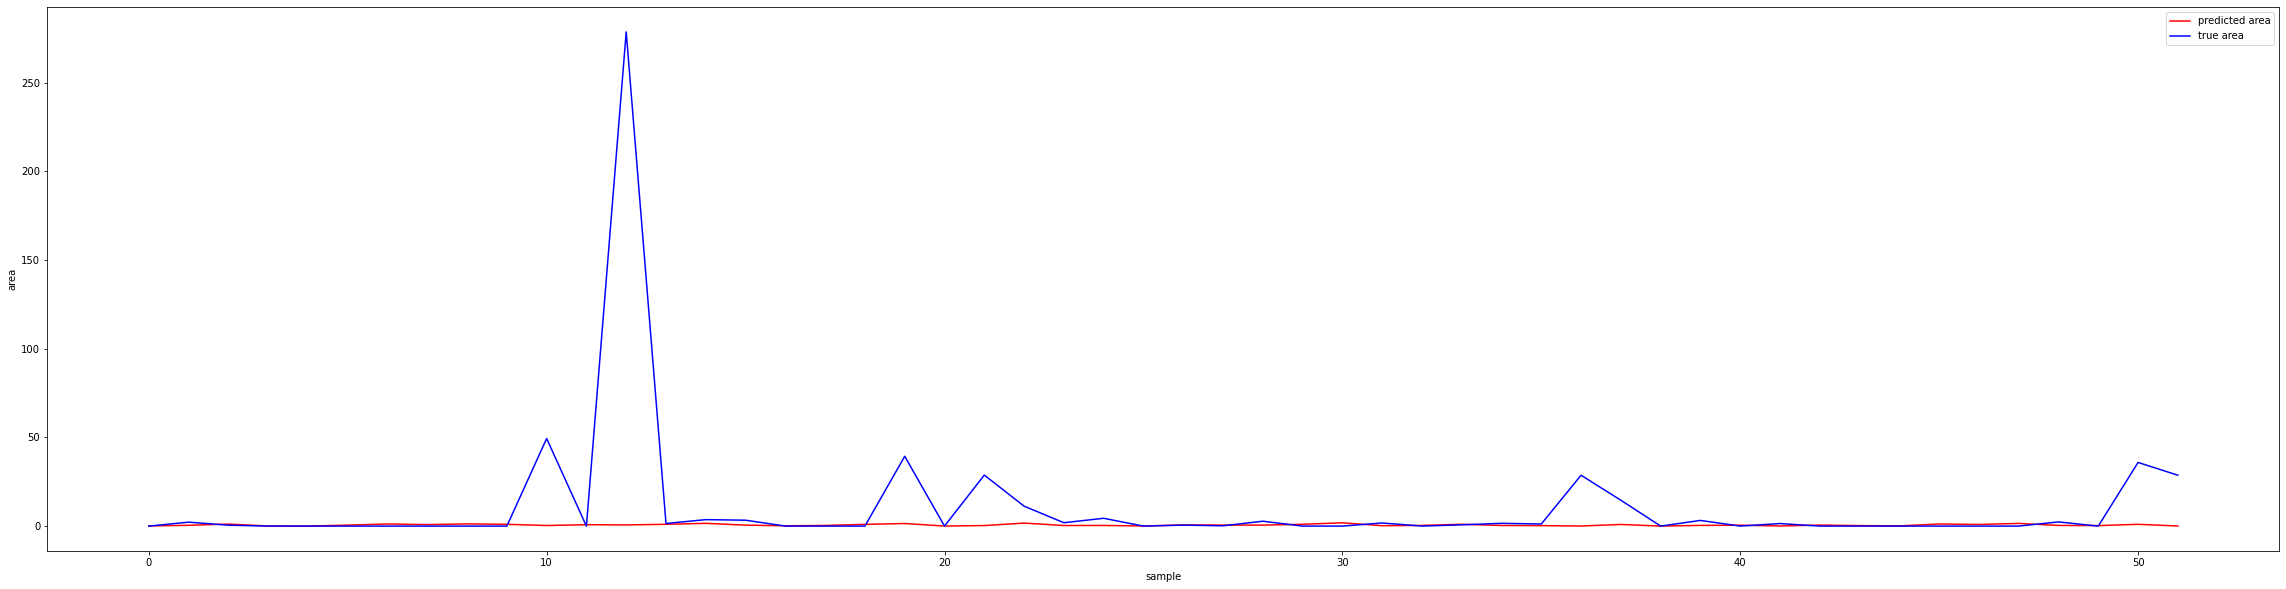

In [427]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(true_pred4,color='r',label='predicted area')
plt.plot(true_y4,color='b',label='true area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')


## 3.6 OneHotEncoder & No Log on Target & Normalisation  & Remove FWIs

In [348]:
##### Prepare Features and Target
X5 = features2.copy() # did OneHot Encoder & Removed FWIs
y5 = target.copy()  # original target
y5 = np.array(y5).reshape(-1,)

In [350]:
##### Split training / test data --- 90% / 10%
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.1, random_state=2)


##### Normalisation Transformation - Rescaling features min=0 max=1
minmaxscale2 = MinMaxScaler(feature_range=(0,1)).fit(X5_train)
X5_train = pd.DataFrame(minmaxscale2.transform(X5_train),columns=X5.columns)
X5_test = pd.DataFrame(minmaxscale2.transform(X5_test),columns=X5.columns)

In [351]:
##### Choose SVR Kernel
parameters5 = [{'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svr_cv5 = GridSearchCV(SVR(), parameters5, cv = 10)
svr_cv5.fit(X5_train, y5_train)

print('Best parameters:',svr_cv5.best_params_)
print('Best estimator:',svr_cv5.best_estimator_)

Best parameters: {'kernel': 'sigmoid'}
Best estimator: SVR(kernel='sigmoid')


In [131]:
##### Choose SVR Parameter
parameters5 = [{'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[1,0.9,0.7,0.5,0.1,1e-2,1e-4,1e-6]}]
svr_cv5 = GridSearchCV(SVR(kernel='sigmoid',epsilon=0.01), parameters5, cv = 10)
svr_cv5.fit(X5_train, y5_train)

print('Best parameters:',svr_cv5.best_params_)
print('Best estimator:',svr_cv5.best_estimator_)

Best parameters: {'C': 1, 'gamma': 0.9}
Best estimator: SVR(C=1, epsilon=0.01, gamma=0.9, kernel='sigmoid')


In [423]:
##### Get Prediction & MAE & RMSE
pre_test5 = svr_cv5.predict(X5_test)
pre_test5[pre_test5<0]=0   # replace negative values to zero

mae_test5 = mean_absolute_error(y5_test, pre_test5)
rmse_test5 = math.sqrt(mean_squared_error(y5_test, pre_test5))
print("MAE on true test set:",mae_test5)
print("RMSE on true test set:",rmse_test5)

MAE on true test set: 11.321192866840219
RMSE on true test set: 40.34964537278118


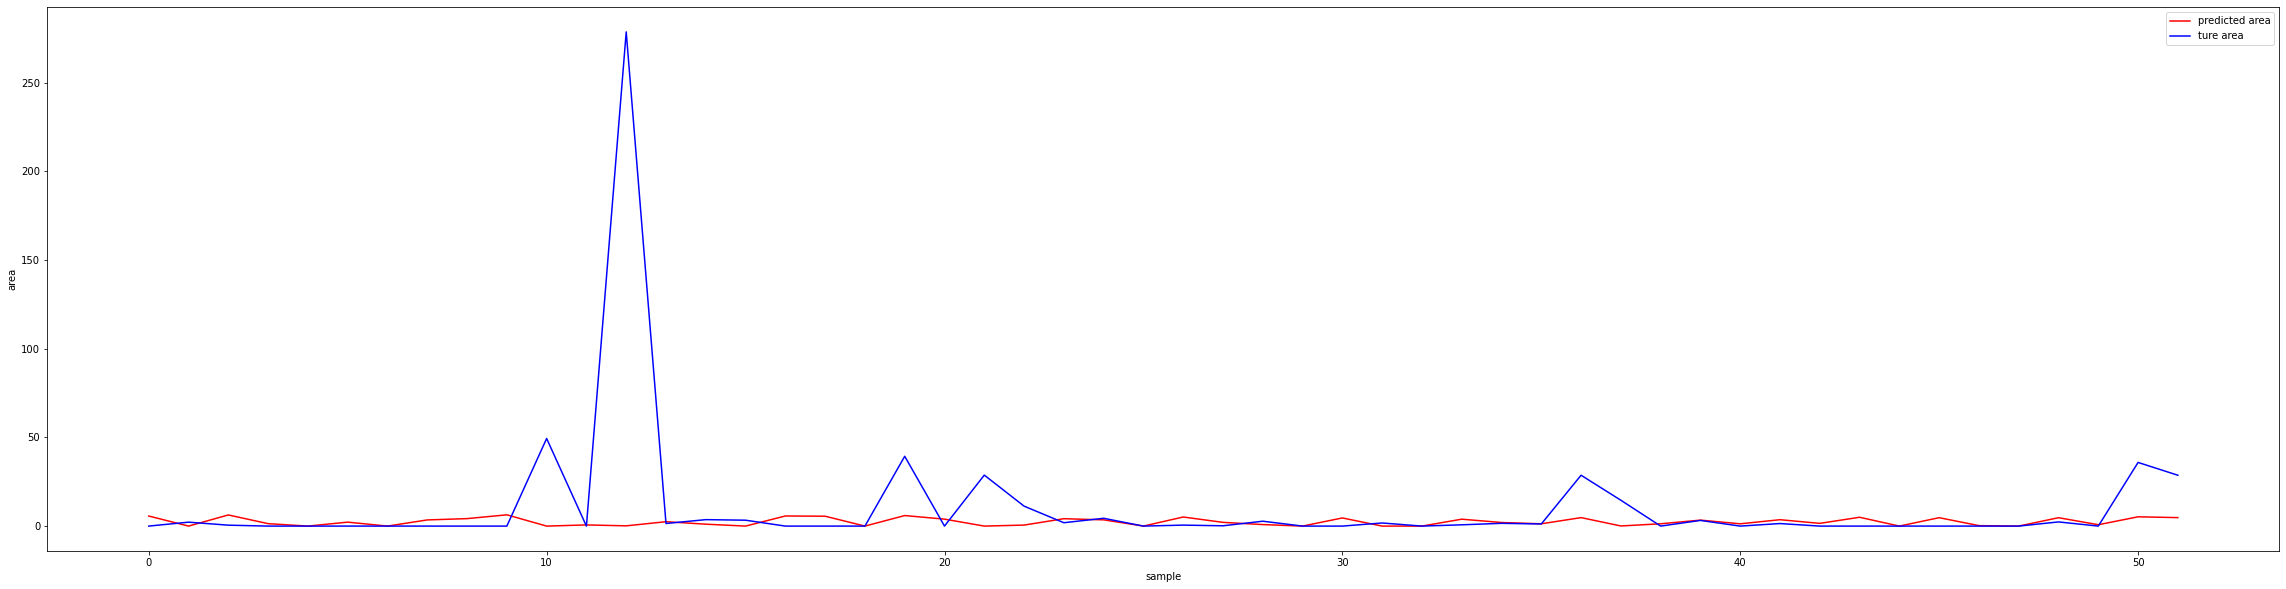

In [424]:
##### Visualise Prediction of True Area
plt.figure(figsize=(40, 10));
plt.plot(pre_test5,color='r',label='predicted area')
plt.plot(y5_test,color='b',label='ture area')
plt.xlabel('sample')
plt.ylabel('area')
plt.legend(loc='best')

## 4. FOR COMPARE PERFORMANCE WITH OTHER MODELS

In [352]:
# features - did OneHot Encoder for month & date // log // removed FWIs   ->  X4 (517,25)
# target - did log transformation    ->  y4 (517,)


from sklearn.model_selection import KFold

kfold = KFold(10, True, 99) # 10 folds
MAE_10 = []
MSE_10 = []
RMSE_10 = []
R2_10 =[]
TIME = []
n=0

for train, test in kfold.split(df):
    
    start = time.time()
    
    # split train/test set
    X_train_10 = X4.values[train]
    y_train_10 = y4[train]
    X_test_10 = X4.values[test]
    y_test_10 = y4[test]
    
    # Rescaling features (min-max normalisation) min=0 max=1
    minmaxscale1 = MinMaxScaler(feature_range=(0,1)).fit(X_train_10)
    X_train_10 = pd.DataFrame(minmaxscale1.transform(X_train_10),columns=X4.columns)
    X_test_10 = pd.DataFrame(minmaxscale1.transform(X_test_10),columns=X4.columns)
    
    # train model with the best parameters
    svr_model = SVR(kernel='rbf', epsilon=0.1, C=1000, gamma=0.0001)
    svr_model.fit(X_train_10, y_train_10)
    
    # get true predicted area
    pred_10 = svr_model.predict(X_test_10)
    pred_10[pred_10 < 0] = 0   
    true_pred_10 = np.expm1(pred_10)
    true_y_10 = np.expm1(y_test_10)  # inverse log transform
    true_y_10[true_y_10 < 0] = 0  # replace negative values to zero
    
    # calculate measurements
    MAE = mean_absolute_error(true_y_10, true_pred_10)
    MSE = mean_squared_error(true_y_10, true_pred_10)
    RMSE = math.sqrt(mean_squared_error(true_y_10, true_pred_10))
    R2 = r2_score(true_y_10, true_pred_10)
    
    n = n + 1
    end = time.time() - start
    
    MAE_10.append(MAE)
    MSE_10.append(MSE)
    RMSE_10.append(RMSE)
    R2_10.append(R2)
    TIME.append(end)
   
    print("Fold:",n)
    print('MAE:',MAE)
    print('MSE:',MSE)
    print('RMSE:',RMSE)
    print('R2:',R2)
    print('time:',end,'\n')
   

Fold: 1
MAE: 7.371804730969592
MSE: 661.1693168598667
RMSE: 25.713212884815984
R2: -0.08094802072981544
time: 0.08614802360534668 

Fold: 2
MAE: 18.244183756710534
MSE: 2597.9662018629015
RMSE: 50.97024820287715
R2: -0.1396856399253248
time: 0.06588912010192871 

Fold: 3
MAE: 9.56147125064128
MSE: 737.0222252551279
RMSE: 27.148153256807873
R2: -0.11177058894418757
time: 0.038416147232055664 

Fold: 4
MAE: 9.661752004969596
MSE: 1107.2958493404894
RMSE: 33.27605519499704
R2: -0.07962996947310907
time: 0.03765296936035156 

Fold: 5
MAE: 9.999589552811162
MSE: 979.1803223267746
RMSE: 31.29185712492588
R2: -0.09068471126196376
time: 0.06017899513244629 

Fold: 6
MAE: 20.103440213791618
MSE: 10860.847325429319
RMSE: 104.21538910079124
R2: -0.03557042534502397
time: 0.030353307723999023 

Fold: 7
MAE: 7.980128220489974
MSE: 276.9363041814372
RMSE: 16.641403311663268
R2: -0.23206551721870206
time: 0.05941009521484375 

Fold: 8
MAE: 7.643068620539939
MSE: 356.3934082362757
RMSE: 18.87838468291

In [309]:
zipped = list(zip(MAE_10,MSE_10,RMSE_10,R2_10,TIME))
result = pd.DataFrame(zipped,columns=['MAE','MSE','RMSE','R2','TIME'])
result.to_csv("[SVR] result.csv")  # for comparison with other models
result.describe()

,MAE,MSE,RMSE,R2,TIME
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,12.793327,4210.680306,49.334475,-0.102431,0.041505
std,6.992118,7488.844275,44.432094,0.059938,0.027340
min,7.371805,276.936304,16.641403,-0.232066,0.022229
25%,8.282272,680.132544,26.071948,-0.132707,0.026050
50%,9.611612,997.291088,31.578614,-0.085816,0.027045
75%,16.183035,2225.298614,46.546700,-0.072157,0.050758
max,28.179129,23514.590253,153.344678,-0.032238,0.104126


## 5. Final SVR Model

In [442]:
##### Read Dataset
# dataset is downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv
svr_df = pd.read_csv("forestfires.csv")


##### OneHot Encoder
month = np.array(svr_df['month']).reshape(-1,1)
day = np.array(svr_df['day']).reshape(-1,1)

label_encoder = OneHotEncoder()

label_encoder.fit(month)
m = label_encoder.transform(month).toarray()

label_encoder.fit(day)
d = label_encoder.transform(day).toarray()

month_df = pd.DataFrame(m, dtype=int)
day_df = pd.DataFrame(d, dtype=int)

svr_df_full = pd.concat([svr_df, month_df, day_df],axis=1) # full dataset 


##### Remove FWIs & Log transform
svr_features = svr_df_full.drop(["month","day","FFMC","DMC","DC","ISI","area"], axis=1)  # Remove FWIs (517, 25)
svr_features[['rain']] = np.log(svr_features[['rain']]+1)
XX = svr_features.copy() # Did OneHot Encoder & Log & Remove FWIs

svr_target = svr_df_full["area"] # target  (517,)
yy = np.log1p(svr_target)  # Log for target
yy = np.array(yy).reshape(-1,)

In [449]:
##### Split training / test data --- 90% / 10%
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.1, random_state=2)


##### Normalisation Transformation - Rescaling features, min=0 max=1
svr_minmaxscale = MinMaxScaler(feature_range=(0,1)).fit(XX_train)
XX_train = pd.DataFrame(svr_minmaxscale.transform(XX_train),columns=XX.columns)
XX_test = pd.DataFrame(svr_minmaxscale.transform(XX_test),columns=XX.columns)

##### train model with the best parameters
svr = SVR(kernel='rbf',epsilon=0.01,gamma=0.0001,C=1000)
svr.fit(XX_train, yy_train)
    
##### get true predicted area
pred_area = svr.predict(XX_test)
pred_area[pred_area < 0] = 0   
true_pred_area = np.expm1(pred_area)
true_yy_test = np.expm1(yy_test)  # inverse log transform
true_yy_test[true_yy_test < 0] = 0  # replace negative values to zero

##### calculate measurements
svr_MAE = mean_absolute_error(true_yy_test, true_pred_area)
svr_MSE = mean_squared_error(true_yy_test, true_pred_area)
svr_RMSE = math.sqrt(mean_squared_error(true_yy_test, true_pred_area))
svr_R2 = r2_score(true_yy_test, true_pred_area)

print("MAE is:",svr_MAE)
print("MSE is:",svr_MSE)
print("RMSE is:",svr_RMSE)
print("R2 is:",svr_R2)

MAE is: 10.588781606437088
MSE is: 1635.8695335797163
RMSE is: 40.44588401283518
R2 is: -0.06371732874484604
